In [1]:
import numpy as np
import cv2
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

from lib import proc_img
from lib import create_gen

def printmd(string):
    #Print with Markdowns    
    display(Markdown(string))
    
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
dataset_name = 'ASL'
dir_ = Path('/home/anjir29/Desktop/all models/data/asl_alphabet_train/asl_alphabet_train')
# dataset_name = 'CIFAR10'
# dir_ = Path('/home/anjir29/Desktop/all models/data/CIFAR-10-images-master/train')
file_paths = list(dir_.glob(r'**/*.jpg'))
print(len(file_paths))

87000


In [3]:
df = proc_img(file_paths)

print(f'Number of pictures in the dataset: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

df.head(5) 

Number of pictures in the dataset: 87000

Number of different labels: 29

Labels: ['D' 'M' 'I' 'Q' 'del' 'V' 'E' 'G' 'K' 'R' 'F' 'nothing' 'B' 'A' 'X' 'U'
 'N' 'C' 'T' 'space' 'L' 'S' 'O' 'Z' 'W' 'P' 'H' 'J' 'Y']


,Filepath,Label
0,/home/anjir29/Desktop/all models/data/asl_alph...,D
1,/home/anjir29/Desktop/all models/data/asl_alph...,M
2,/home/anjir29/Desktop/all models/data/asl_alph...,I
3,/home/anjir29/Desktop/all models/data/asl_alph...,Q
4,/home/anjir29/Desktop/all models/data/asl_alph...,del


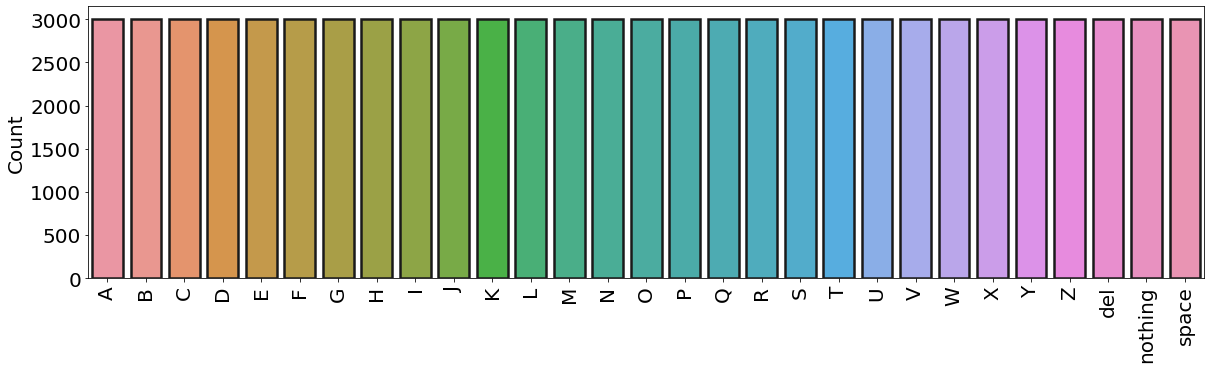

In [4]:
# Display the number of pictures of each category
vc = df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, linewidth=2.5, edgecolor=".1")
plt.xticks(rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.show()

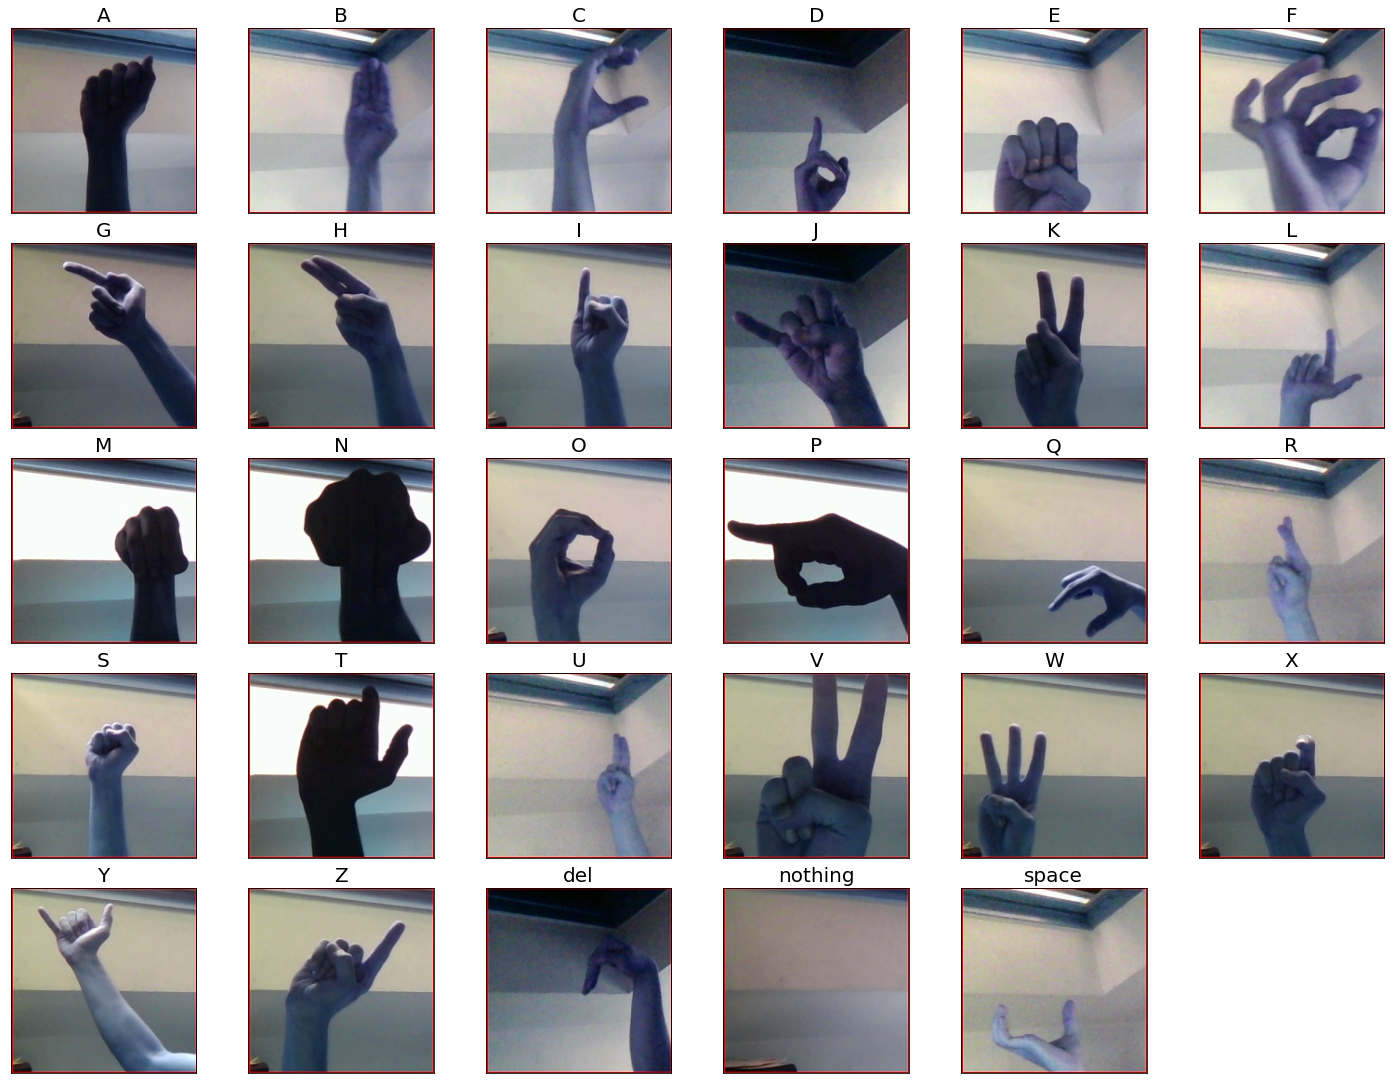

In [5]:
unique_items = df.Label.unique().copy()
unique_items = np.sort(unique_items)

plt.figure(figsize=(20,15))

for i in range(len(unique_items)):
    for j in range(len(df.Label)):
        if df.Label[j] == unique_items[i]:
            plt.subplot(5,6,i+1)
            plt.imshow(cv2.imread(df.Filepath[j]))
            plt.xticks([])
            plt.yticks([])
            plt.title(df.Label[j], fontsize=20)
            i += 1
            break
            
plt.tight_layout(pad=0.5)
plt.show()       

In [6]:
# Use 5% of the dataset for testing various models Split into training and test datasets
train_df, test_df = train_test_split(df.sample(frac = 0.05), test_size=0.2, random_state=0)

In [7]:
img_shape = cv2.imread(df.Filepath[0])

In [8]:
#Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen(train_df, test_df)
print('\n')

Found 3132 validated image filenames belonging to 29 classes.
Found 348 validated image filenames belonging to 29 classes.
Found 870 validated image filenames belonging to 29 classes.




In [9]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'max'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    #x = tf.keras.layers.Flatten()(pretrained_model.output)
    
    x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
                
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [10]:
# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},   
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},   
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},  
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0}, 
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}




DenseNet121


Epoch 1/30
49/49 [==============================] - 93s 1s/step - loss: 3.7771 - accuracy: 0.0897 - val_loss: 2.1587 - val_accuracy: 0.4397
Epoch 2/30
49/49 [==============================] - 12s 237ms/step - loss: 1.9815 - accuracy: 0.4206 - val_loss: 1.0553 - val_accuracy: 0.6782
Epoch 3/30
49/49 [==============================] - 12s 238ms/step - loss: 1.0699 - accuracy: 0.6522 - val_loss: 0.5896 - val_accuracy: 0.8362
Epoch 4/30
49/49 [==============================] - 12s 238ms/step - loss: 0.6436 - accuracy: 0.7896 - val_loss: 0.5742 - val_accuracy: 0.8132
Epoch 5/30
49/49 [==============================] - 12s 238ms/step - loss: 0.4422 - accuracy: 0.8529 - val_loss: 0.3725 - val_accuracy: 0.8822
Epoch 6/30
49/49 [==============================] - 12s 239ms/step - loss: 0.3677 - accuracy: 0.8870 - val_loss: 0.3676 - val_accuracy: 0.8851
Epoch 7/30
49/49 [==============================] - 12s 242ms/step - loss: 0.3016 - accuracy: 0.8995 - val_loss: 0.3469 - val_acc

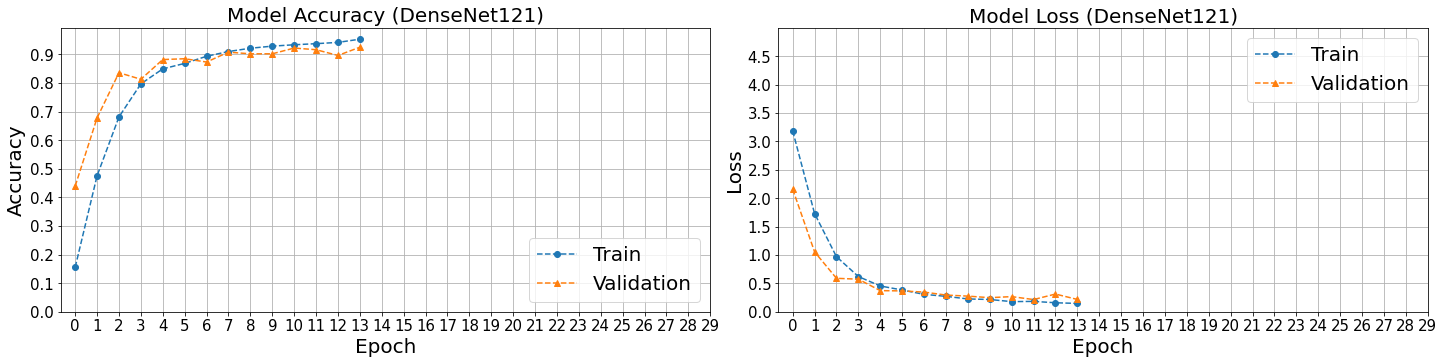

DenseNet121          trained in 249.92 sec


MobileNetV2


Epoch 1/30
49/49 [==============================] - 10s 158ms/step - loss: 4.4779 - accuracy: 0.0531 - val_loss: 2.7686 - val_accuracy: 0.1925
Epoch 2/30
49/49 [==============================] - 6s 130ms/step - loss: 2.5393 - accuracy: 0.2555 - val_loss: 1.3592 - val_accuracy: 0.5632
Epoch 3/30
49/49 [==============================] - 6s 129ms/step - loss: 1.3334 - accuracy: 0.5682 - val_loss: 0.7661 - val_accuracy: 0.7471
Epoch 4/30
49/49 [==============================] - 6s 129ms/step - loss: 0.8664 - accuracy: 0.7034 - val_loss: 0.6727 - val_accuracy: 0.7615
Epoch 5/30
49/49 [==============================] - 6s 129ms/step - loss: 0.6622 - accuracy: 0.7807 - val_loss: 0.6205 - val_accuracy: 0.7759
Epoch 6/30
49/49 [==============================] - 6s 130ms/step - loss: 0.5583 - accuracy: 0.8183 - val_loss: 0.3559 - val_accuracy: 0.8764
Epoch 7/30
49/49 [==============================] - 6s 130ms/step - loss: 0.4219 - accur

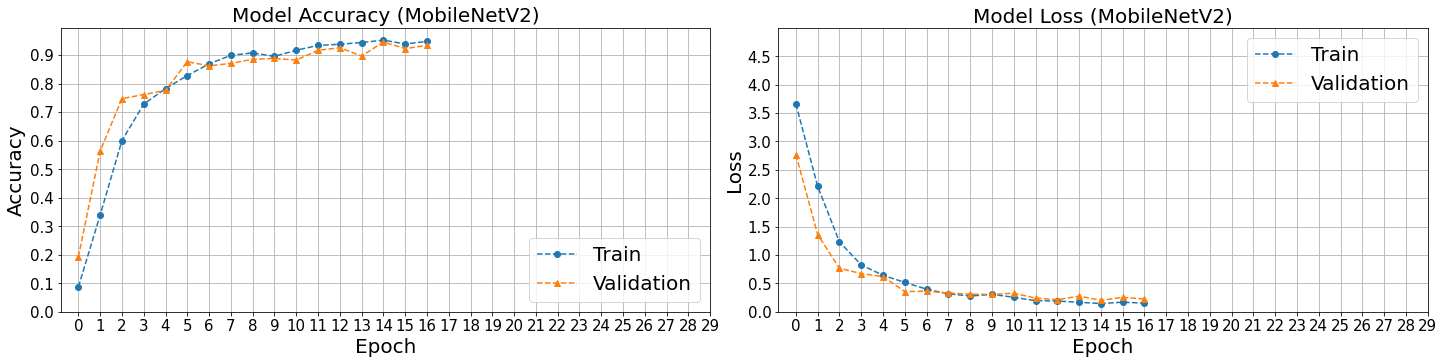

MobileNetV2          trained in 114.82 sec


DenseNet169


Epoch 1/30
49/49 [==============================] - 25s 362ms/step - loss: 3.7257 - accuracy: 0.0868 - val_loss: 1.9202 - val_accuracy: 0.5057
Epoch 2/30
49/49 [==============================] - 14s 293ms/step - loss: 1.7251 - accuracy: 0.4783 - val_loss: 0.8939 - val_accuracy: 0.7385
Epoch 3/30
49/49 [==============================] - 14s 294ms/step - loss: 0.8685 - accuracy: 0.7249 - val_loss: 0.6033 - val_accuracy: 0.8218
Epoch 4/30
49/49 [==============================] - 14s 293ms/step - loss: 0.5143 - accuracy: 0.8336 - val_loss: 0.4255 - val_accuracy: 0.8649
Epoch 5/30
49/49 [==============================] - 14s 294ms/step - loss: 0.3611 - accuracy: 0.8899 - val_loss: 0.3633 - val_accuracy: 0.8793
Epoch 6/30
49/49 [==============================] - 14s 294ms/step - loss: 0.2721 - accuracy: 0.9103 - val_loss: 0.3365 - val_accuracy: 0.8736
Epoch 7/30
49/49 [==============================] - 14s 294ms/step - loss: 0.2467 -

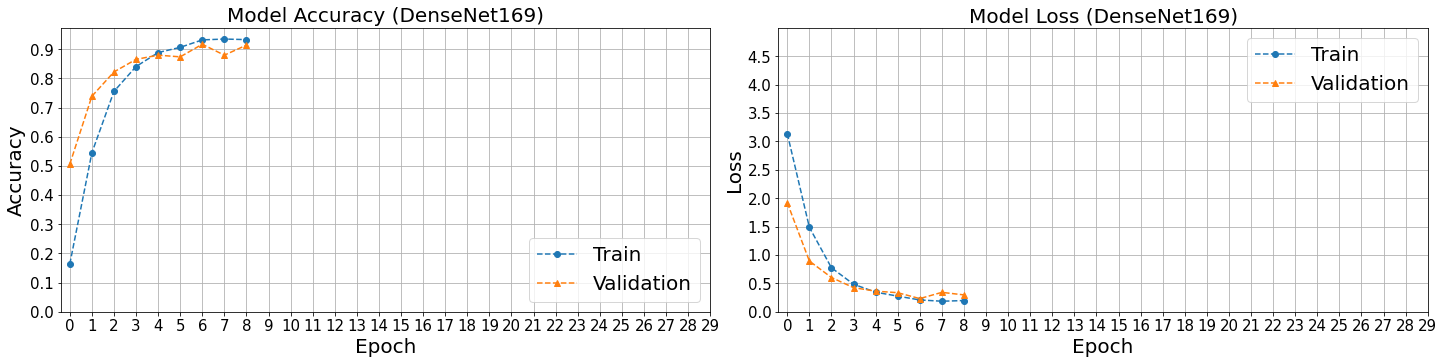

DenseNet169          trained in 141.88 sec


DenseNet201


Epoch 1/30
49/49 [==============================] - 31s 461ms/step - loss: 3.5580 - accuracy: 0.1262 - val_loss: 1.4626 - val_accuracy: 0.6178
Epoch 2/30
49/49 [==============================] - 18s 371ms/step - loss: 1.3588 - accuracy: 0.5721 - val_loss: 0.6813 - val_accuracy: 0.8046
Epoch 3/30
49/49 [==============================] - 18s 371ms/step - loss: 0.6898 - accuracy: 0.7719 - val_loss: 0.3972 - val_accuracy: 0.8793
Epoch 4/30
49/49 [==============================] - 18s 371ms/step - loss: 0.4152 - accuracy: 0.8622 - val_loss: 0.3839 - val_accuracy: 0.8420
Epoch 5/30
49/49 [==============================] - 18s 371ms/step - loss: 0.3071 - accuracy: 0.8930 - val_loss: 0.2502 - val_accuracy: 0.9224
Epoch 6/30
49/49 [==============================] - 18s 372ms/step - loss: 0.2428 - accuracy: 0.9232 - val_loss: 0.3094 - val_accuracy: 0.8966
Epoch 7/30
49/49 [==============================] - 18s 372ms/step - loss: 0.1994 -

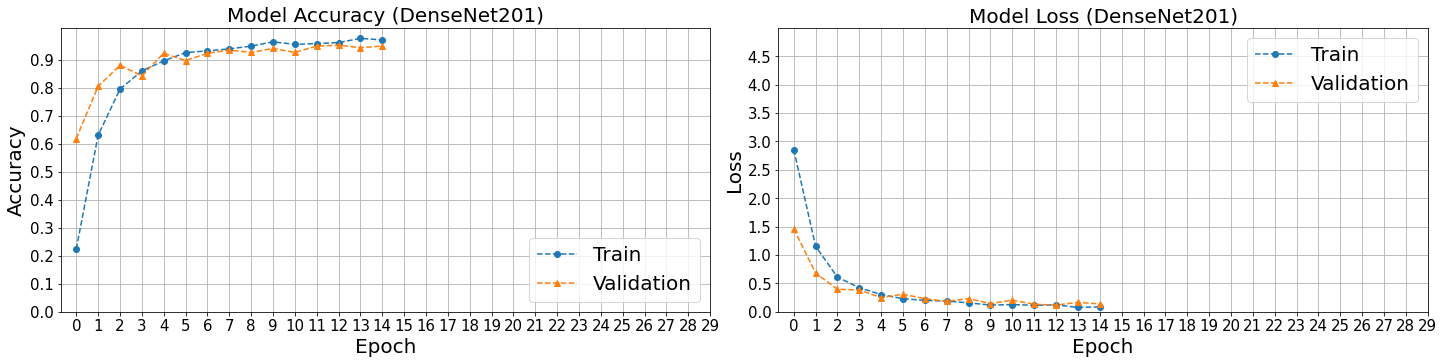

DenseNet201          trained in 288.51 sec


InceptionV3


Epoch 1/30
49/49 [==============================] - 16s 236ms/step - loss: 4.1727 - accuracy: 0.0515 - val_loss: 2.7854 - val_accuracy: 0.2759
Epoch 2/30
49/49 [==============================] - 9s 173ms/step - loss: 2.7185 - accuracy: 0.2241 - val_loss: 1.7953 - val_accuracy: 0.5057
Epoch 3/30
49/49 [==============================] - 8s 171ms/step - loss: 1.7890 - accuracy: 0.4691 - val_loss: 1.2157 - val_accuracy: 0.6293
Epoch 4/30
49/49 [==============================] - 8s 171ms/step - loss: 1.2847 - accuracy: 0.5866 - val_loss: 0.9592 - val_accuracy: 0.7328
Epoch 5/30
49/49 [==============================] - 8s 171ms/step - loss: 1.0119 - accuracy: 0.6805 - val_loss: 0.9528 - val_accuracy: 0.6724
Epoch 6/30
49/49 [==============================] - 8s 170ms/step - loss: 0.8576 - accuracy: 0.7175 - val_loss: 0.9440 - val_accuracy: 0.6695
Epoch 7/30
49/49 [==============================] - 9s 172ms/step - loss: 0.7748 - accur

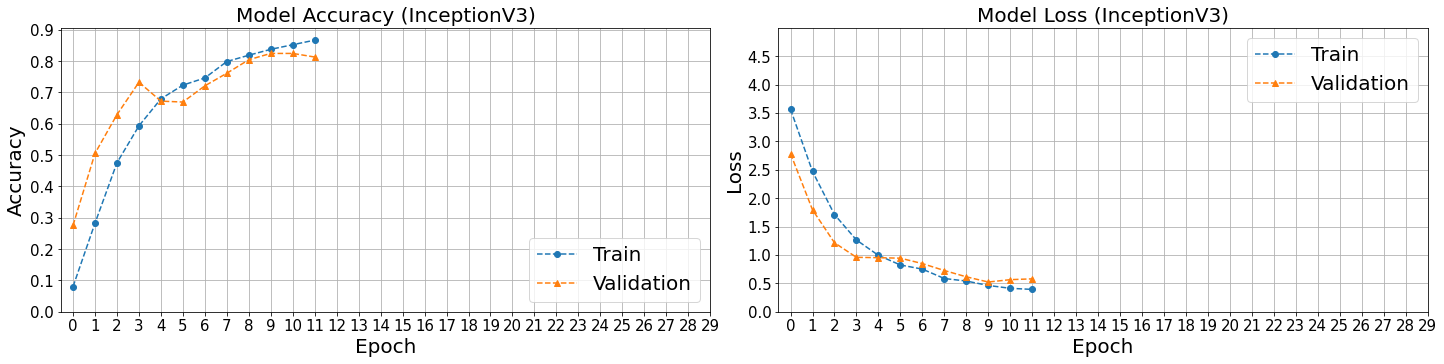

InceptionV3          trained in 110.1 sec


MobileNet


Epoch 1/30
49/49 [==============================] - 9s 150ms/step - loss: 4.2206 - accuracy: 0.0589 - val_loss: 2.6349 - val_accuracy: 0.2931
Epoch 2/30
49/49 [==============================] - 6s 128ms/step - loss: 2.4322 - accuracy: 0.2947 - val_loss: 1.2072 - val_accuracy: 0.6437
Epoch 3/30
49/49 [==============================] - 6s 128ms/step - loss: 1.1749 - accuracy: 0.6334 - val_loss: 0.5158 - val_accuracy: 0.8333
Epoch 4/30
49/49 [==============================] - 6s 128ms/step - loss: 0.6554 - accuracy: 0.7735 - val_loss: 0.4140 - val_accuracy: 0.8822
Epoch 5/30
49/49 [==============================] - 6s 128ms/step - loss: 0.4632 - accuracy: 0.8454 - val_loss: 0.3449 - val_accuracy: 0.8822
Epoch 6/30
49/49 [==============================] - 6s 128ms/step - loss: 0.3526 - accuracy: 0.8889 - val_loss: 0.3073 - val_accuracy: 0.8908
Epoch 7/30
49/49 [==============================] - 6s 125ms/step - loss: 0.3062 - accuracy:

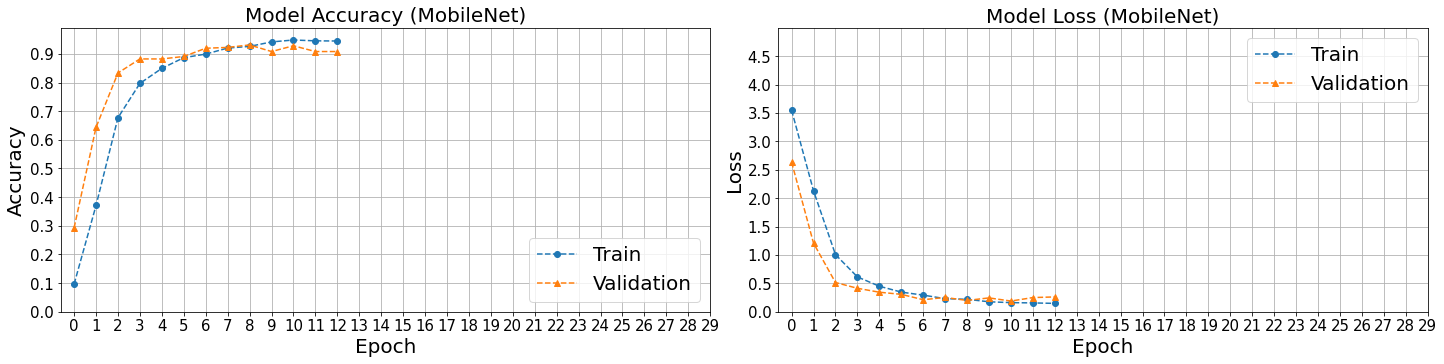

MobileNet            trained in 86.68 sec


ResNet101


Epoch 1/30
49/49 [==============================] - 31s 531ms/step - loss: 3.7257 - accuracy: 0.0620 - val_loss: 3.0629 - val_accuracy: 0.1466
Epoch 2/30
49/49 [==============================] - 23s 478ms/step - loss: 2.9636 - accuracy: 0.1523 - val_loss: 2.5391 - val_accuracy: 0.2701
Epoch 3/30
49/49 [==============================] - 23s 477ms/step - loss: 2.5120 - accuracy: 0.2525 - val_loss: 2.2495 - val_accuracy: 0.2989
Epoch 4/30
49/49 [==============================] - 24s 481ms/step - loss: 2.2548 - accuracy: 0.3157 - val_loss: 2.0366 - val_accuracy: 0.3994
Epoch 5/30
49/49 [==============================] - 23s 478ms/step - loss: 2.0107 - accuracy: 0.3756 - val_loss: 1.9451 - val_accuracy: 0.4023
Epoch 6/30
49/49 [==============================] - 24s 479ms/step - loss: 1.8717 - accuracy: 0.4126 - val_loss: 1.7390 - val_accuracy: 0.4598
Epoch 7/30
49/49 [==============================] - 23s 478ms/step - loss: 1.6621 - ac

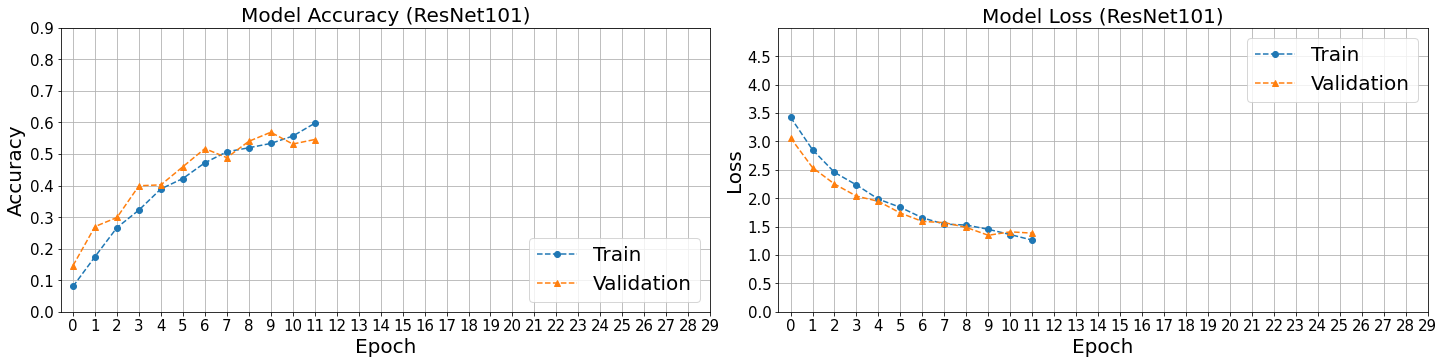

ResNet101            trained in 291.18 sec


ResNet152


Epoch 1/30
49/49 [==============================] - 42s 735ms/step - loss: 3.5623 - accuracy: 0.0571 - val_loss: 3.0611 - val_accuracy: 0.1092
Epoch 2/30
49/49 [==============================] - 33s 674ms/step - loss: 2.8946 - accuracy: 0.1766 - val_loss: 2.4770 - val_accuracy: 0.2730
Epoch 3/30
49/49 [==============================] - 33s 678ms/step - loss: 2.3502 - accuracy: 0.3187 - val_loss: 2.2102 - val_accuracy: 0.3046
Epoch 4/30
49/49 [==============================] - 33s 679ms/step - loss: 2.0472 - accuracy: 0.3766 - val_loss: 1.8243 - val_accuracy: 0.4167
Epoch 5/30
49/49 [==============================] - 33s 678ms/step - loss: 1.8038 - accuracy: 0.4555 - val_loss: 1.7002 - val_accuracy: 0.4828
Epoch 6/30
49/49 [==============================] - 33s 679ms/step - loss: 1.6101 - accuracy: 0.4956 - val_loss: 1.4491 - val_accuracy: 0.5546
Epoch 7/30
49/49 [==============================] - 33s 678ms/step - loss: 1.4481 - a

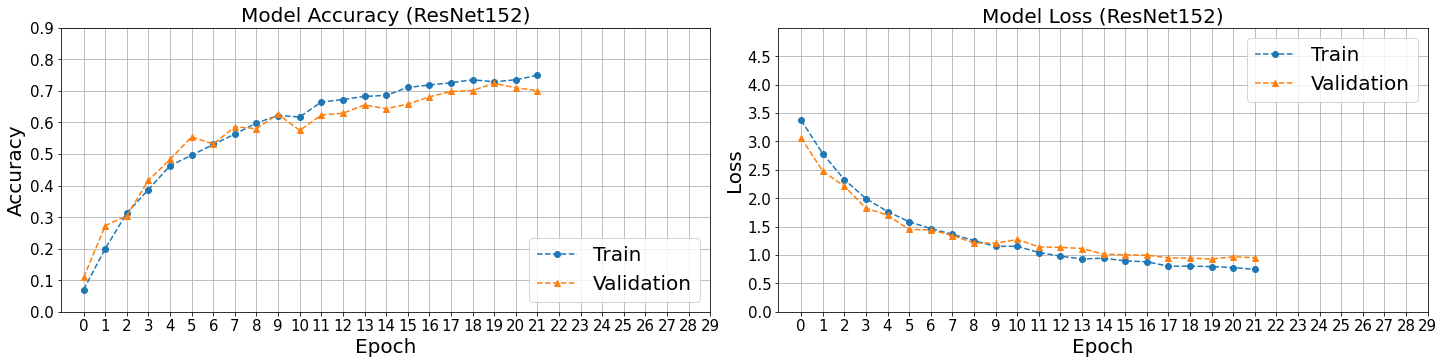

ResNet152            trained in 742.46 sec


ResNet50


Epoch 1/30
49/49 [==============================] - 18s 314ms/step - loss: 3.6789 - accuracy: 0.0560 - val_loss: 3.1230 - val_accuracy: 0.1178
Epoch 2/30
49/49 [==============================] - 15s 296ms/step - loss: 2.9966 - accuracy: 0.1482 - val_loss: 2.6868 - val_accuracy: 0.2155
Epoch 3/30
49/49 [==============================] - 15s 297ms/step - loss: 2.6717 - accuracy: 0.2193 - val_loss: 2.4615 - val_accuracy: 0.2356
Epoch 4/30
49/49 [==============================] - 15s 297ms/step - loss: 2.3780 - accuracy: 0.2851 - val_loss: 2.3103 - val_accuracy: 0.2874
Epoch 5/30
49/49 [==============================] - 15s 297ms/step - loss: 2.2215 - accuracy: 0.3189 - val_loss: 2.1054 - val_accuracy: 0.3391
Epoch 6/30
49/49 [==============================] - 15s 297ms/step - loss: 2.0166 - accuracy: 0.3609 - val_loss: 1.9447 - val_accuracy: 0.3994
Epoch 7/30
49/49 [==============================] - 15s 296ms/step - loss: 1.9140 - ac

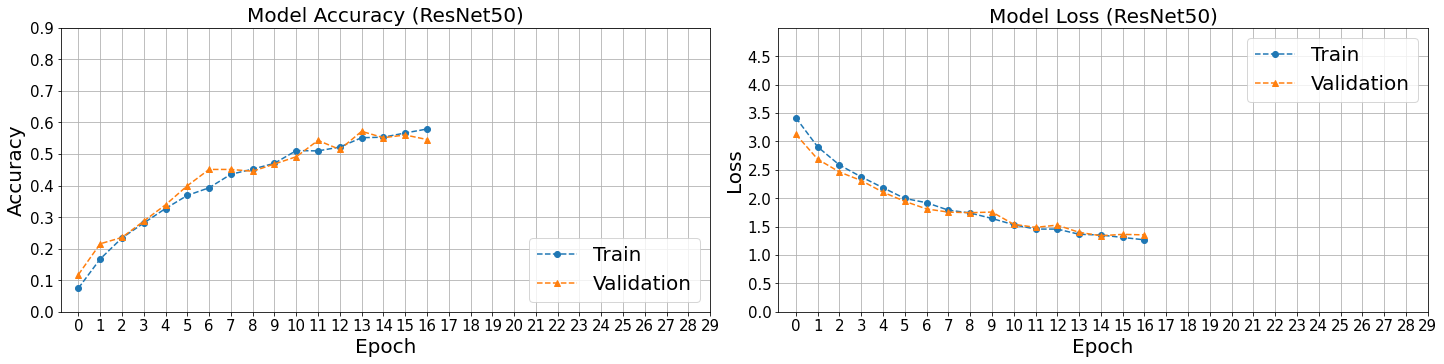

ResNet50             trained in 252.92 sec


VGG16


Epoch 1/30
49/49 [==============================] - 41s 614ms/step - loss: 3.1513 - accuracy: 0.1419 - val_loss: 1.6627 - val_accuracy: 0.5431
Epoch 2/30
49/49 [==============================] - 15s 300ms/step - loss: 1.4710 - accuracy: 0.5587 - val_loss: 0.7072 - val_accuracy: 0.8190
Epoch 3/30
49/49 [==============================] - 15s 299ms/step - loss: 0.7143 - accuracy: 0.7860 - val_loss: 0.4519 - val_accuracy: 0.8420
Epoch 4/30
49/49 [==============================] - 15s 299ms/step - loss: 0.4774 - accuracy: 0.8502 - val_loss: 0.3099 - val_accuracy: 0.9080
Epoch 5/30
49/49 [==============================] - 15s 299ms/step - loss: 0.3083 - accuracy: 0.9018 - val_loss: 0.2322 - val_accuracy: 0.9253
Epoch 6/30
49/49 [==============================] - 15s 299ms/step - loss: 0.2286 - accuracy: 0.9289 - val_loss: 0.2181 - val_accuracy: 0.9368
Epoch 7/30
49/49 [==============================] - 15s 299ms/step - loss: 0.1810 - accur

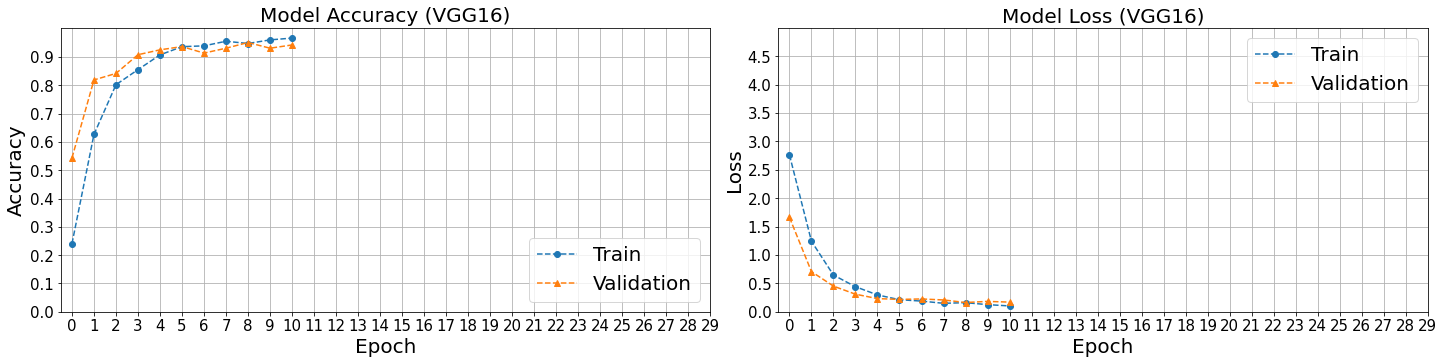

VGG16                trained in 189.6 sec


VGG19


Epoch 1/30
49/49 [==============================] - 18s 362ms/step - loss: 3.2088 - accuracy: 0.1136 - val_loss: 1.7513 - val_accuracy: 0.5287
Epoch 2/30
49/49 [==============================] - 18s 356ms/step - loss: 1.6062 - accuracy: 0.5219 - val_loss: 0.9742 - val_accuracy: 0.7098
Epoch 3/30
49/49 [==============================] - 18s 356ms/step - loss: 0.9504 - accuracy: 0.7009 - val_loss: 0.5613 - val_accuracy: 0.8247
Epoch 4/30
49/49 [==============================] - 18s 356ms/step - loss: 0.5932 - accuracy: 0.8147 - val_loss: 0.5091 - val_accuracy: 0.8448
Epoch 5/30
49/49 [==============================] - 18s 356ms/step - loss: 0.4539 - accuracy: 0.8544 - val_loss: 0.4833 - val_accuracy: 0.8218
Epoch 6/30
49/49 [==============================] - 18s 356ms/step - loss: 0.3600 - accuracy: 0.8867 - val_loss: 0.3342 - val_accuracy: 0.9023
Epoch 7/30
49/49 [==============================] - 18s 356ms/step - loss: 0.3115 - accura

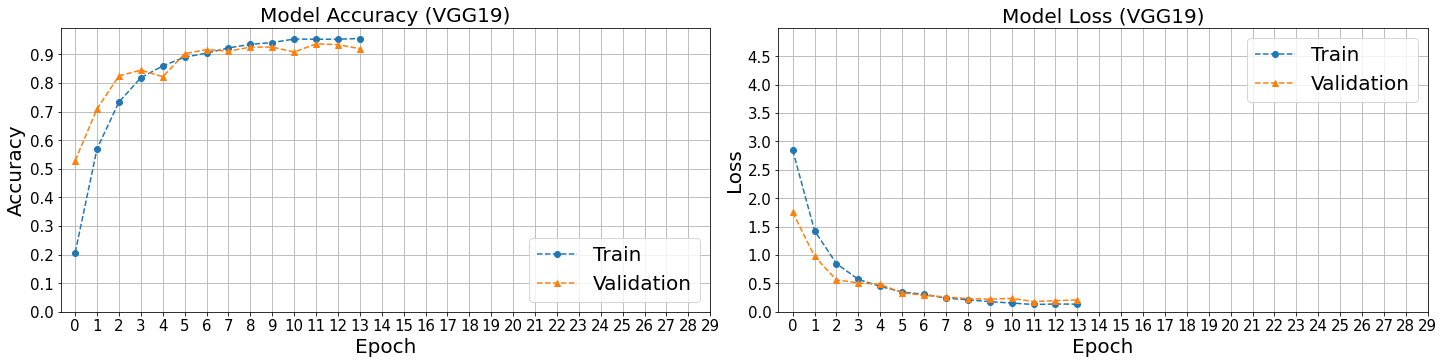

VGG19                trained in 247.57 sec


Xception


Epoch 1/30
49/49 [==============================] - 22s 383ms/step - loss: 3.0910 - accuracy: 0.1628 - val_loss: 1.5396 - val_accuracy: 0.5431
Epoch 2/30
49/49 [==============================] - 17s 337ms/step - loss: 1.3916 - accuracy: 0.5660 - val_loss: 0.8602 - val_accuracy: 0.7040
Epoch 3/30
49/49 [==============================] - 17s 337ms/step - loss: 0.7557 - accuracy: 0.7501 - val_loss: 0.6121 - val_accuracy: 0.7730
Epoch 4/30
49/49 [==============================] - 17s 337ms/step - loss: 0.5150 - accuracy: 0.8251 - val_loss: 0.4965 - val_accuracy: 0.8391
Epoch 5/30
49/49 [==============================] - 17s 338ms/step - loss: 0.3855 - accuracy: 0.8770 - val_loss: 0.4056 - val_accuracy: 0.8420
Epoch 6/30
49/49 [==============================] - 17s 338ms/step - loss: 0.2798 - accuracy: 0.9076 - val_loss: 0.3872 - val_accuracy: 0.8678
Epoch 7/30
49/49 [==============================] - 17s 337ms/step - loss: 0.2513 - ac

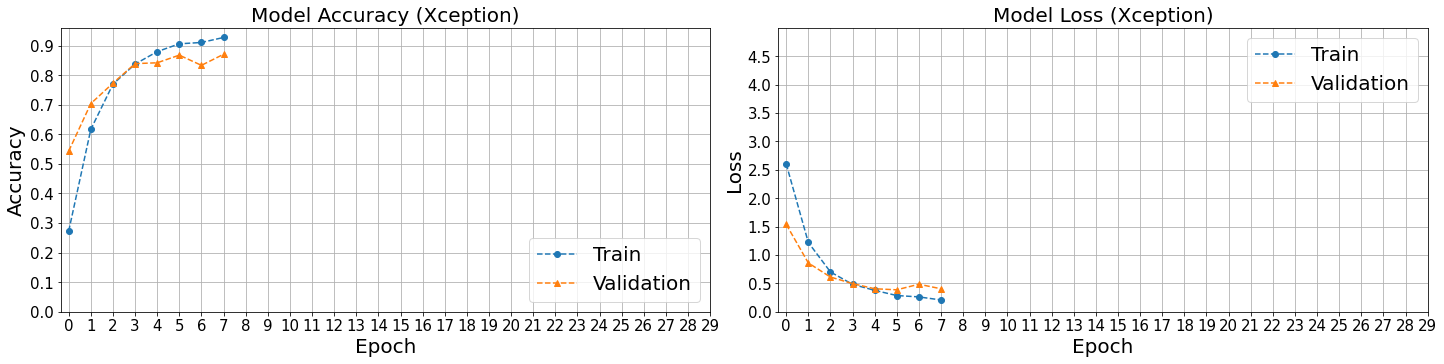

Xception             trained in 138.89 sec


In [11]:
# Fit the models
maxEpochs = 30
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    print(f"\n\n{name}\n\n")
    start = perf_counter()
    
    
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=2)
    history = m.fit(train_images,validation_data=val_images, epochs=maxEpochs, verbose=1, callbacks=early_stop)
       
        
    fig = plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], "--o")
    plt.plot(history.history['val_accuracy'], "--^")
    plt.title(f"Model Accuracy ({name})", fontsize=20)
    plt.xticks(np.arange(0, maxEpochs, 1), fontsize=15) 
    plt.yticks(np.arange(0, 1, 0.1), fontsize=15) 
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Epoch', fontsize=20)
    plt.grid(True)
    plt.legend(['Train', 'Validation'], fontsize=20, loc='lower right')

    plt.subplot(1,2,2)
    # summarize history for loss
    plt.plot(history.history['loss'], "--o")
    plt.plot(history.history['val_loss'], "--^")
    plt.title(f"Model Loss ({name})", fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.xlabel('Epoch', fontsize=20)
    plt.xticks(np.arange(0, maxEpochs, 1), fontsize=15) 
    plt.yticks(np.arange(0, 5, 0.5), fontsize=15) 
    plt.ylim([0, 5])
    plt.grid(True)
    plt.legend(['Train', 'Validation'], fontsize=20, loc='upper right')
    
    plt.tight_layout(pad=0.5)
    plt.show()
    fig.savefig(f"results/{name}.pdf", dpi = 100)
    plt.close(fig) 
                
    # Fit the model
    # history = m.fit(train_images,validation_data=val_images,epochs=3,verbose=1)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    #m.save(f"all_models/{name}")



In [27]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,Training time (sec)
0,DenseNet201,0.9483,288.51
1,VGG16,0.9425,189.60
2,MobileNetV2,0.9339,114.82
3,DenseNet121,0.9253,249.92
4,VGG19,0.9195,247.57
5,DenseNet169,0.9138,141.88
6,MobileNet,0.9080,86.68
7,Xception,0.8707,138.89
8,InceptionV3,0.8132,110.10
9,ResNet152,0.7011,742.46


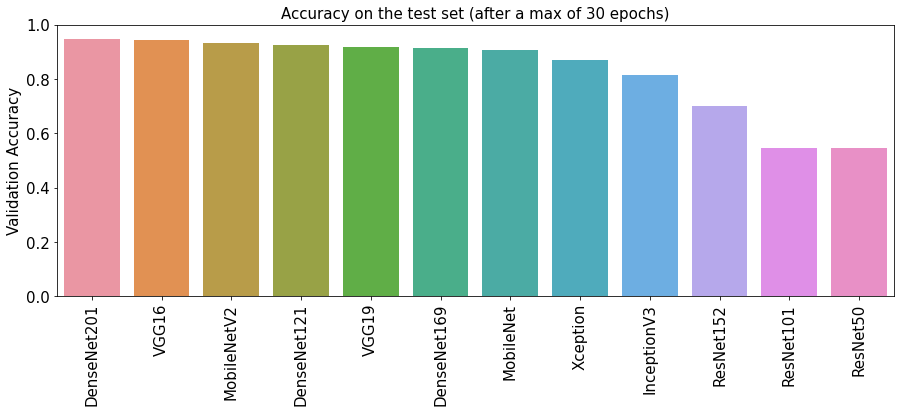

In [28]:
fig = plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the test set (after a max of 30 epochs)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Validation Accuracy",fontsize=15)
plt.xlabel("")
plt.show()
#fig.savefig(f"results/all_val_acc.jpg", dpi = 100)
plt.close(fig)

In [82]:
from gtts import gTTS  
from playsound import playsound  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


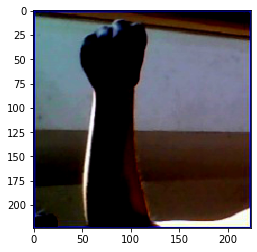

In [83]:
img=test_images[0][0][5]
plt.imshow(img)

In [84]:
img = img.reshape(1,224,224,3) 

In [85]:
predictions = m.predict(img)
predictions=np.argmax(predictions, axis=1) 

In [86]:
predictions[0]

12

In [87]:
def switch_demo(argument):
    switcher = {
        0: "A",
        1: "B",
        2: "C",
        3: "D",
        4: "E",
        5: "F",
        6: "G",
        7: "H",
        8: "I",
        9: "J",
        10: "K",
        11: "L",
        12: "M",
        13: "N",
        14: "O",
        15: "P",
        16: "Q",
        17: "R",
        18: "S",
        19: "T",
        20: "U",
        21: "V",
        22: "W",
        23: "X",
        24: "Y",
        25: "Z",
        26: "Del",
        27: "nothing",
        28: "Space",
    }
    print (switcher.get(argument, "Invalid month"))

In [ ]:
text_val = str(switch_demo(predictions[0])) 
language = 'en'  
obj = gTTS(text=text_val, lang=language, slow=False)  
obj.save(text_val+".mp3")  
playsound(text_val+".mp3")  